# User Mood

This model is trained to detect if a user face is happy, sad, or angry. It can be extended with further training to include other (more nuanced) moods as well.

First, import all necessary packages for notebook

In [92]:
from duckduckgo_search import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

Next, build a search function for DuckDuckGo

In [93]:
def search_images(term): 
    return L(DDGS().images(term)).itemgot('image')

Test the download process to make sure it works

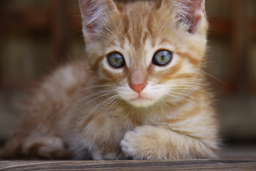

In [94]:
dest = 'test/cat.jpg'
download_url(search_images('cat')[0], dest, show_progress=False)

img = Image.open(dest)
img.to_thumb(256, 256)


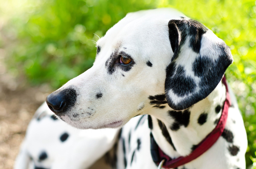

In [95]:
dest = 'test/dog.jpg'
download_url(search_images('dog')[0], dest, show_progress=False)

img = Image.open(dest)
img.to_thumb(256, 256)

Next, do a iterative download for bulk data to use in training the vision model

In [96]:
# This variable is abstracted so that it can be run every time
path = Path("images")

searches = [
    "cat",
    "dog",
]

In [48]:
# This should only be run once

# for search in searches:
#     dest = (path/search)
#     dest.mkdir(exist_ok=True, parents=True)
#     download_images(dest, urls=search_images(f"{search} animal"), max_pics=100)

#     resize_image(dest/search, max_size=400, dest=path/search)

Next, I manually scrubbed the image data downloaded in order to ensure the iamges are good.

After that, we must set up a DataBlock to then pull our data loaders from:

In [97]:
animals = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

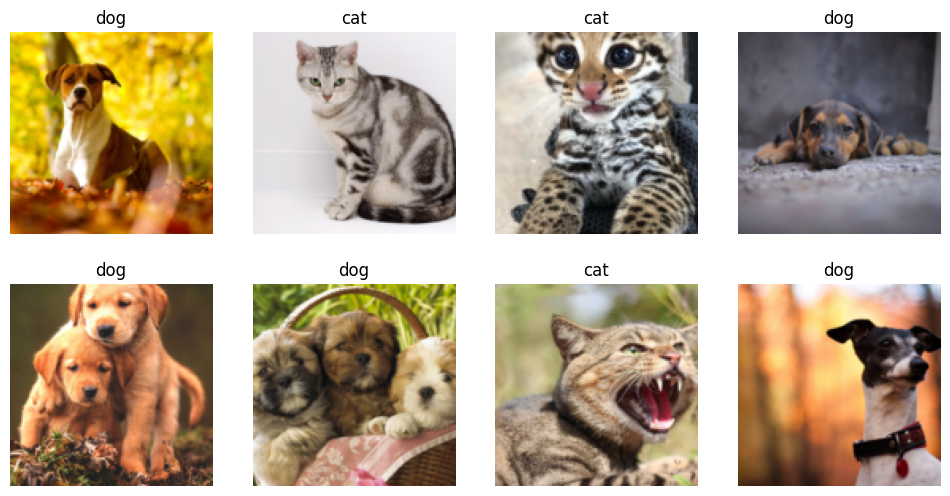

In [98]:
dataloader = animals.dataloaders(path)

dataloader.valid.show_batch(max_n=8, nrows=2)

The images need to be standardized, so let's resize them.

We can use a `RandomResizedCrop` process that allows us to do "Data Augmentation"

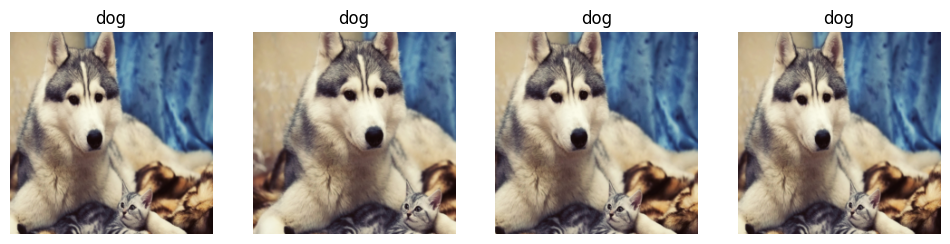

In [99]:
animals = animals.new(item_tfms=RandomResizedCrop(224, min_scale=0.5))

dataloader = animals.dataloaders(path)
dataloader.train.show_batch(max_n=4, nrows=1, unique=True)

Now that our data is cleaned and we have our `dataloader`, we can go ahead and train our model.

In [122]:
learn = vision_learner(dataloader, resnet18, metrics=error_rate)

learn.fine_tune(5)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.972460,0.090234,0.020202,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.167307,0.107421,0.030303,00:22
1,0.120698,0.154334,0.040404,00:21
2,0.093004,0.211719,0.050505,00:21
3,0.083492,0.202362,0.030303,00:21
4,0.066293,0.188149,0.030303,00:21


A good next step is to check the confusion matrix to check in our our model:

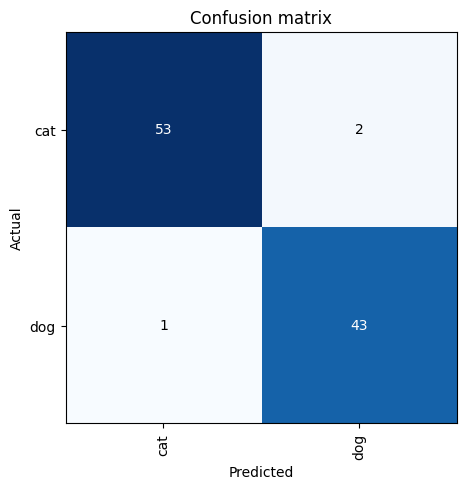

In [123]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

We can see what our models are with the top prediction/actual and loss/probability issues:

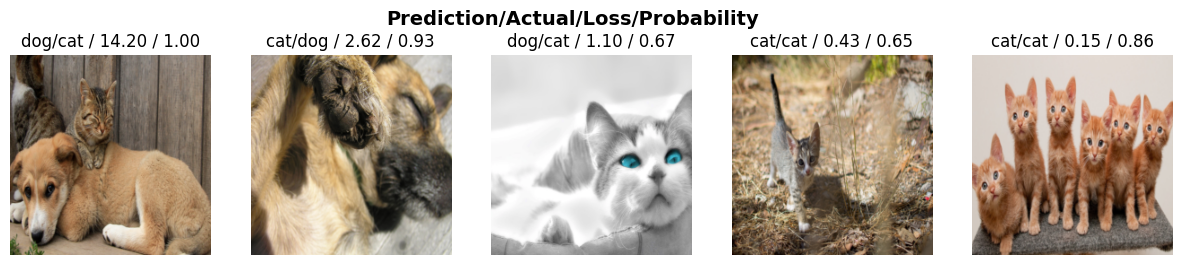

In [124]:
interp.plot_top_losses(5, nrows=1)

In [76]:
# cleaner = ImageClassifierCleaner(learn)
# cleaner

Finally, we can export the trained model like so:

In [125]:
learn.export()

We should verify that it exists which can be a simple path check:

In [127]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

Lastly, we can test this is working properly with the following code:

In [129]:
model = load_learner(path/'export.pkl')

catagory,_,pred = model.predict('test/cartoon-cat.jpg')

print(catagory)

cat


In [111]:
model.dls.vocab

['cat', 'dog']